# UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS
### AGE & TIME OF DAY analysis on SPEEDING CITATIONS with no labeled clusters

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  


I downloaded the data in September 2018, September 2019, and January 2020.  In raw format the combined dataset includes just over XXK rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
%matplotlib inline 
sns.set(style='darkgrid')
plt.rcParams['patch.edgecolor'] = 'none'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [4]:
# convert column labels to lower case and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [5]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [9]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [10]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

In [11]:
# one citation has no age
# drop citations where age isn't provided

citations.dropna(subset=['cited_person_age'], inplace=True)

In [12]:
citations.cited_person_sex.value_counts()

M    35199
F    21220
U       14
Name: cited_person_sex, dtype: int64

In [13]:
# 14 citations have no gender
# drop citations where gender isn't binary
citations.drop(citations[citations.cited_person_sex == 'U'].index, inplace=True)

In [14]:
# verify non-binary genders have been dropped
citations.cited_person_sex.value_counts()

M    35184
F    21216
Name: cited_person_sex, dtype: int64

In [15]:
# how many rows and columns are in the dataset?
citations.shape

(56403, 22)

## DEFINE FEATURES TO PERFORM ANALYSIS ON

In [142]:
citations.charge_description.value_counts()

Speed Greater Than R&P or Posted                        13343
Expired/No Arizona Registration                          4597
Suspended/Revoked D.L.                                   3382
DUI-Impaired to Slightest Degree                         2742
Failure to Control Speed to Avoid A Collision            2670
                                                        ...  
Liquor-Allow Custmer Bring On Prem                          1
Theft -- Pocket Pick                                        1
Theft-Unauthorized Service/Property-Entrusted Person        1
Liquor-Unlawful Purchase/Gift Employee                      1
Permittee Must Possess Instruction Permit                   1
Name: charge_description, Length: 417, dtype: int64

In [26]:
# subset data to only speeding citations
speeding_citations = citations[citations.charge_description == 'Speed Greater Than R&P or Posted']

In [29]:
speeding_citations[['citation_time', 'cited_person_age']]

,citation_time,cited_person_age
0,747,19.0
1,800,36.0
2,853,61.0
3,843,59.0
4,2215,23.0
...,...,...
22397,1944,29.0
22398,1450,51.0
22400,935,62.0
22415,2300,21.0


In [139]:
speeding_citations.shape

(13343, 22)

In [56]:
# assign X
# leave y value labels out since 
# I'm only interested in visualizing general clusters
X = speeding_citations[['citation_time', 'cited_person_age']]

## VISUALIZE CLUSTERS

### PCA

In [32]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

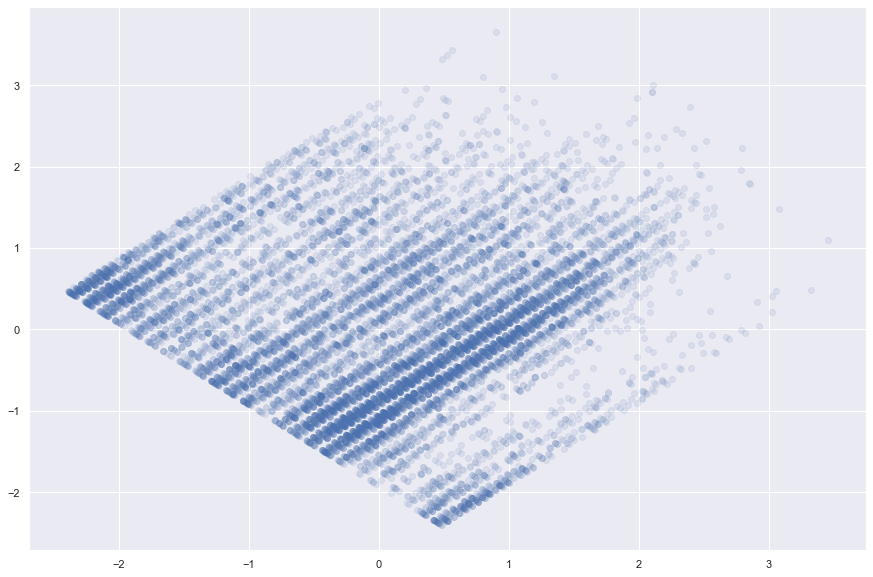

In [34]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.1)

### t-SNE

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13343 samples in 0.005s...
[t-SNE] Computed neighbors for 13343 samples in 0.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13343
[t-SNE] Computed conditional probabilities for sample 2000 / 13343
[t-SNE] Computed conditional probabilities for sample 3000 / 13343
[t-SNE] Computed conditional probabilities for sample 4000 / 13343
[t-SNE] Computed conditional probabilities for sample 5000 / 13343
[t-SNE] Computed conditional probabilities for sample 6000 / 13343
[t-SNE] Computed conditional probabilities for sample 7000 / 13343
[t-SNE] Computed conditional probabilities for sample 8000 / 13343
[t-SNE] Computed conditional probabilities for sample 9000 / 13343
[t-SNE] Computed conditional probabilities for sample 10000 / 13343
[t-SNE] Computed conditional probabilities for sample 11000 / 13343
[t-SNE] Computed conditional probabilities for sample 12000 / 13343
[t-SNE] Computed conditional probabilities for sa

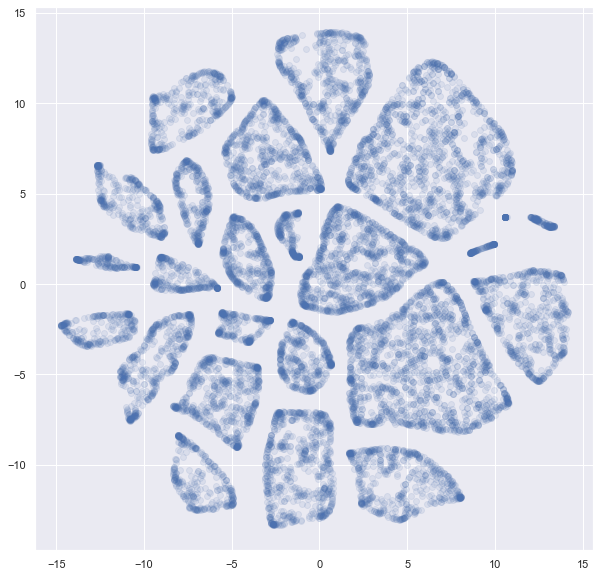

In [36]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1)

### UMAP - iteration 1

In [103]:
umap_results = umap.UMAP(min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

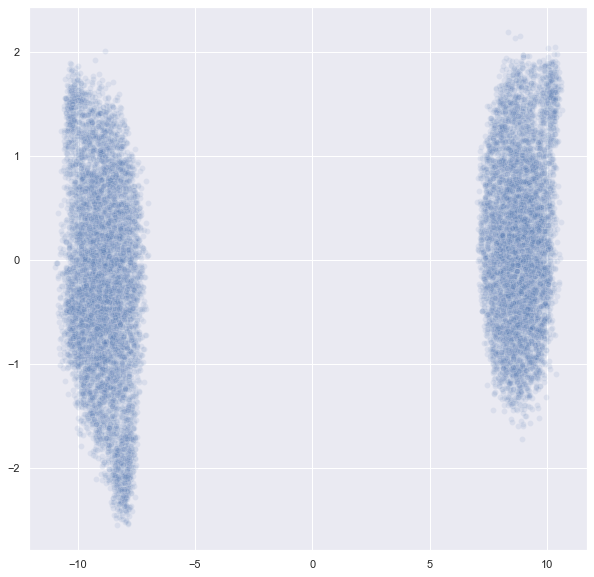

In [46]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1)

### UMAP - iteration 2

In [49]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=1,
                      metric='correlation').fit_transform(X)

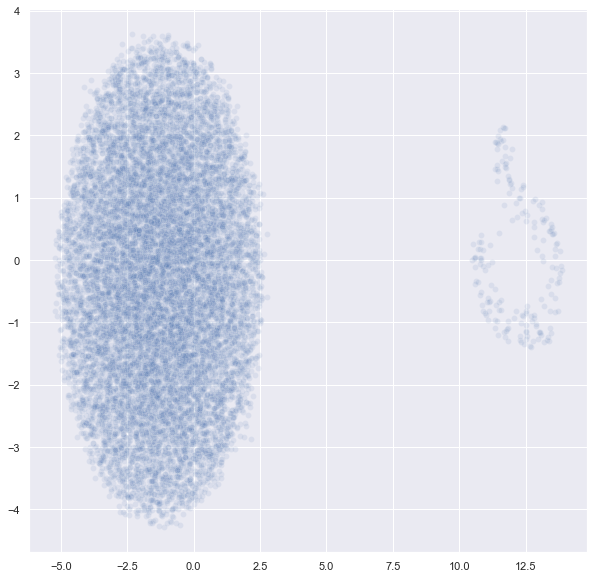

In [50]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1)

## EXAMINE CLUSTER FIT BASED ON CLUSTER METHOD USING *SILHOUETTE*

In [118]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means with 5 clusters

In [119]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.383

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [120]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [121]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.341

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [122]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [123]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.32

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [124]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [125]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.319

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [126]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [127]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.187

## tied

In [128]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [129]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.37

## diag

In [130]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [131]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.216

## spherical

In [132]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [133]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.375

In [134]:
results_df

,silhouette
hierarchical - ward,0.341
hierarchical - complete,0.32
hierarchical - average,0.319
k-means,0.383
gaussian - full,0.187
gaussian - tied,0.37
gaussian - diag,0.216
gaussian - spherical,0.375


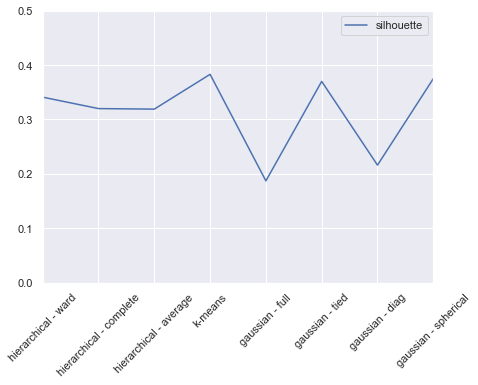

In [138]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45)
plt.ylim(0,.5);

## DBSCAN

In [51]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,11,1):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [53]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,11,1):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [54]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

,min_samples,eps
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1
10,1,1


Text(0, 0.5, 'Clusters')

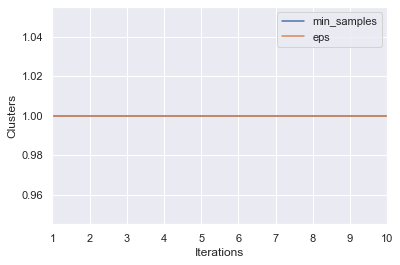

In [55]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')

Why am I not able to get more than one cluster?

# Revisit computations for above amounts

## k-means - visualize with n_clusters=3

In [100]:
# silhouette
labels = KMeans(n_clusters=3).fit_predict(X_std)

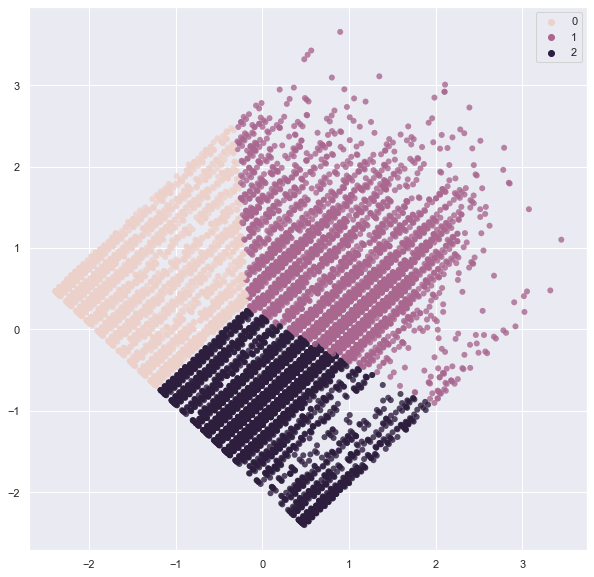

In [105]:
plt.figure(figsize=(10, 10))

sns.scatterplot(X_pca[:, 0], 
                X_pca[:, 1], 
               alpha=.8, 
             hue=pd.Series(labels),
               edgecolor='none')

In [101]:
pd.Series(labels).value_counts()

2    5401
1    4537
0    3405
dtype: int64

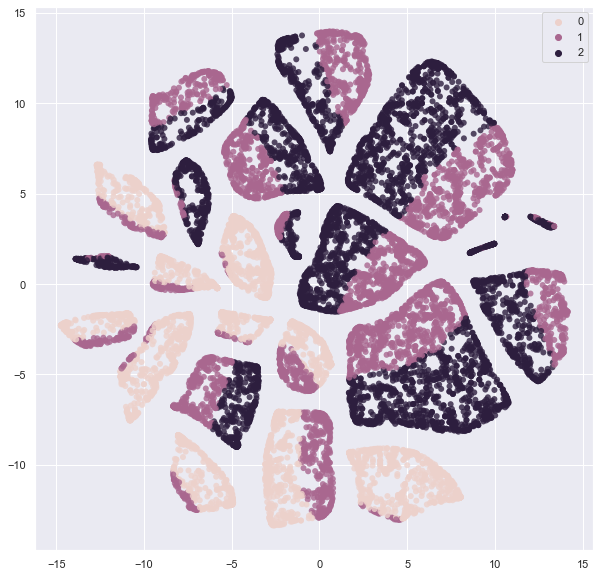

In [102]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=pd.Series(labels),
               edgecolor='none')

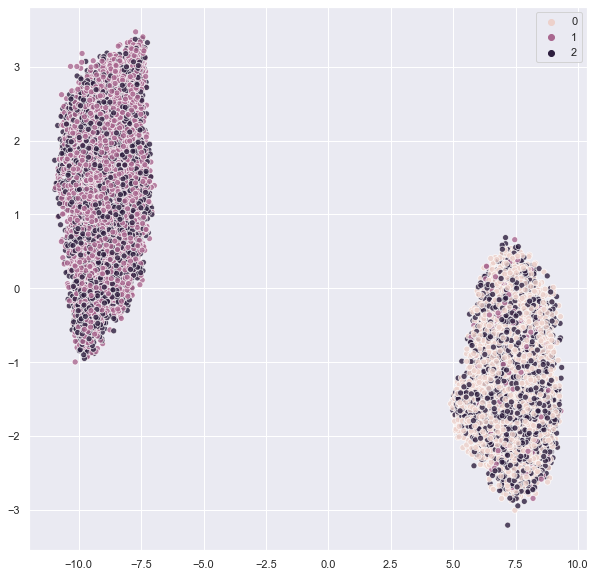

In [104]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0],
                y=umap_results[:, 1], 
                alpha=.8, 
                hue=pd.Series(labels))
plt.legend(loc='best')

## k-means - visualize with n_clusters=5

In [106]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

In [107]:
pd.Series(labels).value_counts()

0    3993
3    3185
2    2610
4    1816
1    1739
dtype: int64

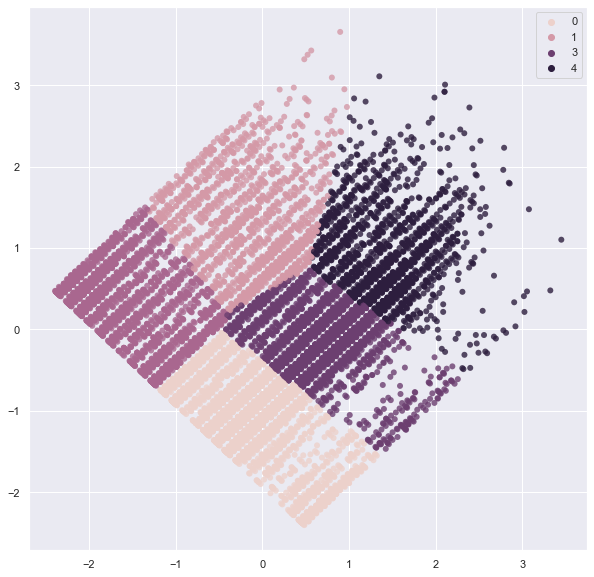

In [108]:
plt.figure(figsize=(10, 10))

sns.scatterplot(X_pca[:, 0], 
                X_pca[:, 1], 
               alpha=.8, 
             hue=pd.Series(labels),
               edgecolor='none')

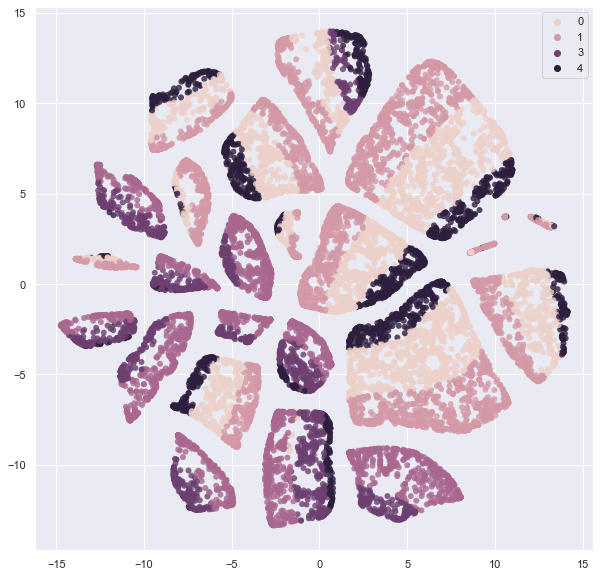

In [95]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=pd.Series(labels),
               edgecolor='none')

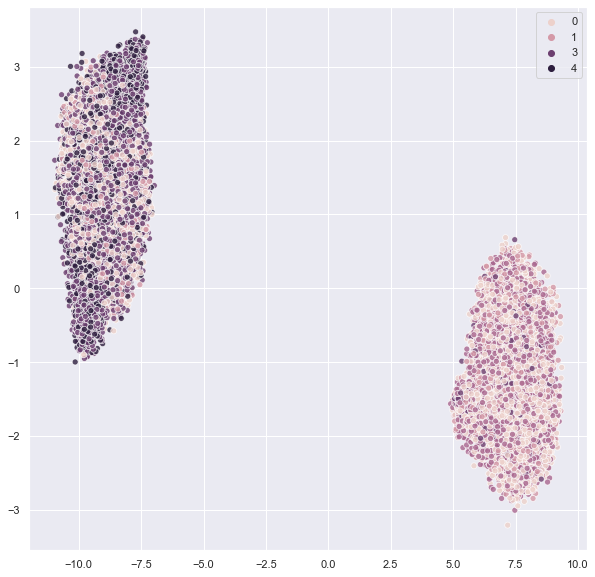

In [109]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0],
                y=umap_results[:, 1], 
                alpha=.8, 
                hue=pd.Series(labels))
plt.legend(loc='best')

## k-means - visualize with n_clusters=10

In [110]:
# silhouette
labels = KMeans(n_clusters=10).fit_predict(X_std)

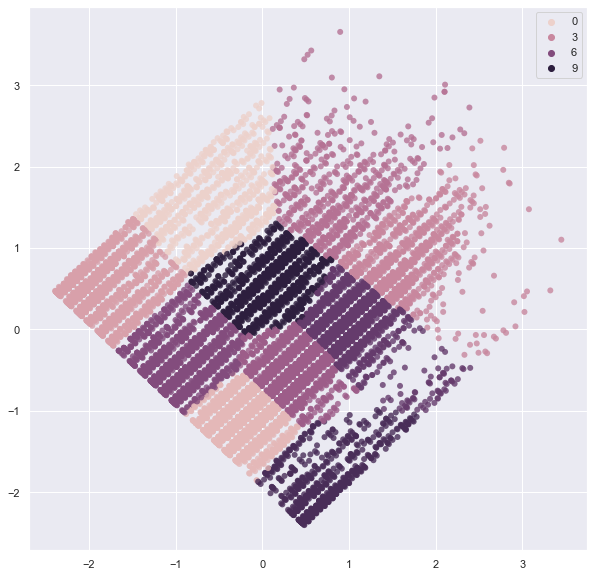

In [111]:
plt.figure(figsize=(10, 10))

sns.scatterplot(X_pca[:, 0], 
                X_pca[:, 1], 
               alpha=.8, 
             hue=pd.Series(labels),
               edgecolor='none')

In [112]:
pd.Series(labels).value_counts()

1    2097
7    1802
5    1772
2    1674
6    1498
9    1215
3     986
0     894
4     704
8     701
dtype: int64

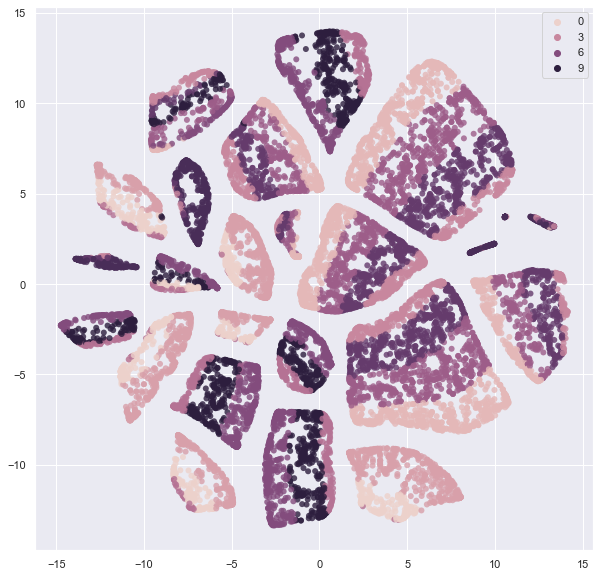

In [113]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=pd.Series(labels),
               edgecolor='none')

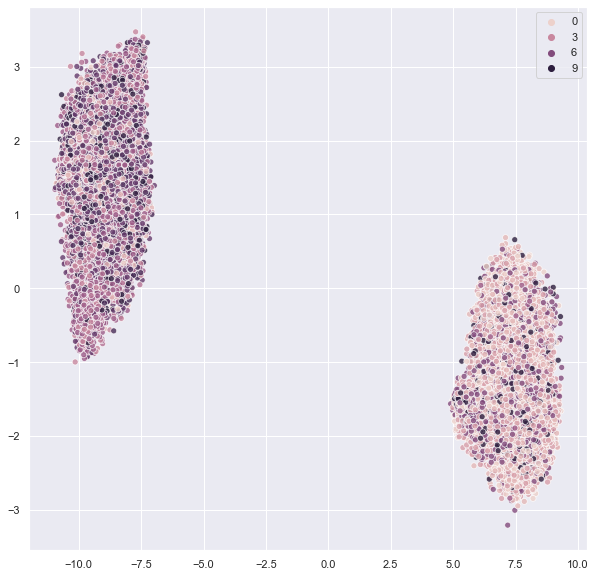

In [114]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0],
                y=umap_results[:, 1], 
                alpha=.8, 
                hue=pd.Series(labels))
plt.legend(loc='best')

# Spare Parts

## 2. GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS USING *ARI*
I will focus on K-means since it performed best above

## K-means with 5 clusters

In [115]:
cluster_number = []
ari_score = []

for i in range(3,21,1):
    cluster_number.append(i)
   
    # Fit model
    clusters = KMeans(n_clusters=i).fit_predict(X_std)
    ari_score.append(round(metrics.adjusted_rand_score(y, y_pred), 3))
    
ari_score

NameError: name 'y' is not defined

In [58]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)


0.383

In [60]:
# ARI
y_pred = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y_pred), 3)


In [117]:
round(metrics.adjusted_rand_score(labels_pred=y_pred), 3)

TypeError: adjusted_rand_score() missing 1 required positional argument: 'labels_true'

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [61]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [62]:
# # examine Adjusted Rand Index (ARI) and the silhouette scores
# results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

In [63]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.341

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [64]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [65]:
# # examine Adjusted Rand Index (ARI) and the silhouette scores
# results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

In [66]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.32

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [67]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [69]:
# # examine Adjusted Rand Index (ARI) and the silhouette scores
# results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

In [70]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.319

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [71]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [72]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.187

In [73]:
# results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

## tied

In [74]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [75]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.37

In [76]:
# results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

## diag

In [77]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [78]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.216

In [79]:
# results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

## spherical

In [80]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [81]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.375

In [82]:
# results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
# round(metrics.adjusted_rand_score(y, clusters), 3)

In [83]:
results_df

,ARI,silhouette
hierarchical - ward,NaN,0.341
hierarchical - complete,NaN,0.32
hierarchical - average,NaN,0.319
k-means,NaN,0.383
gaussian - full,NaN,0.187
gaussian - tied,NaN,0.37
gaussian - diag,NaN,0.216
gaussian - spherical,NaN,0.375


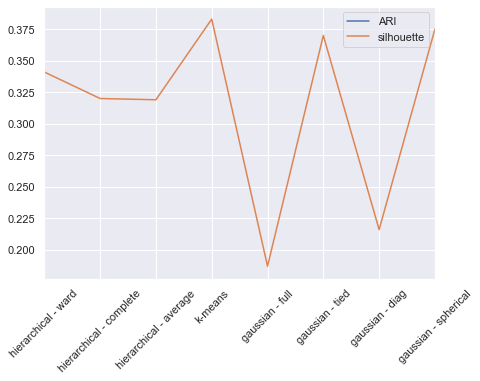

In [84]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);